# Imports

In [469]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import os

# 1.1 Getting Correspondences
<p>We will be using the SIFT descriptor as it is able to do both Feature Extraction/Detection and Feature description, and from the feature descriptors, we can easily match the features. </p>

<p>We will apply the SIFT descriptor on the first frame of the book.mov and cv_cover.jpg. </p>

<h3> Few Notes</h3>

<p>In SIFT, we use gray-scale image, because SIFT heavily relies on gradient calculations to extract features like blobs, so SIFT just relies on intensity values and does not care about color. This also improves performance.</p> 
<p>So the gray-scale conversion is just to make the algorithm work efficiently and focus on structure (edges/corners), not color.</p>

<p>Gaussian Pyramid note:  
<ul>
<li>Multiple scales of image with one Gaussian sigma</li>
<li>is the same as multiple sigmas of gaussian on one scale of image</li>
</ul>
</p>

In [470]:
def read_image(image_relative_path):
    root = os.getcwd()
    imgPath = os.path.join(root, image_relative_path)
    
    # read image
    img = cv.imread(imgPath)
    
    return img

In [471]:
def get_frame(frame_num,capture):
    # set the frame position
    capture.set(cv.CAP_PROP_POS_FRAMES, frame_num)
    
    # read the frame
    ret, frame = capture.read()
    
    return ret, frame

In [472]:
def image2gray(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [473]:
def SIFT(image):

    # image in gray scale
    imgGray = image2gray(image)

    # create sift
    sift = cv.SIFT_create()

    # find keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(imgGray, None)  # None is in place of a binary mask (none means don't exclude any pixels)

    # draw keypoints
    imgKeypoints = cv.drawKeypoints(imgGray, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # show image
    plt.imshow(imgKeypoints)
    plt.axis('off')
    plt.title('SIFT Keypoints')
    plt.show()

    return keypoints, descriptors

In [474]:
def knnBruteForce(descriptor1,descriptor2):
    # create brute force matcher
    bf = cv.BFMatcher() # default match is L2 Distance, which is good for SIFT
    nNeighbors = 2
    matches = bf.knnMatch(descriptor1, descriptor2, k=nNeighbors) # get best 2 matches of each key-point is descriptor1
    # matches is best 2 matches in descriptor2 for each key-point in descriptor1

    nNeighbors = 2
    matches = bf.knnMatch(descriptor1, descriptor2, k=nNeighbors)

    goodMatches_50 = [None] * 50
    testRatio = 0.3
    i = 0
    for m, n in matches: # m is best match, and n is second best (m and n are keypoints in img2)
        if m.distance < testRatio * n.distance:
            goodMatches_50[i] = [m] # to drawMatchesKnn, it expects a list of lists of DMatch objects
            i+=1
            if i == 50: # we only want 50 matches
                print("Found 50 good matches")            
                break
    return goodMatches_50

def drawMatches(img1, img2, kp1, kp2, goodMatches):
    imgMatch = cv.drawMatchesKnn(
        img1, kp1, img2, kp2, goodMatches, None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure()
    plt.imshow(imgMatch)
    plt.axis('off')
    plt.title('Matches')
    plt.show()



In [475]:
def knnBruteForce2a(descriptor1, kp1, descriptor2, kp2):
    # Create Brute-Force matcher with default settings (L2 norm for SIFT)
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptor1, descriptor2, k=2)

    goodMatches = []
    src_pts = []  
    dst_pts = []
    testRatio = 0.3

    for m, n in matches:
        if m.distance < testRatio * n.distance:
            goodMatches.append(m)  # Just append the best match, not [m]
            src_pts.append(kp1[m.queryIdx].pt)  # Append the point from the first image
            dst_pts.append(kp2[m.trainIdx].pt)  # Append the point from the second image
            if len(goodMatches) == 50:
                print("Found 50 good matches")
                break

    # Extract corresponding points from the good matches
    # src_pts = np.float32([kp1[m.queryIdx].pt for m in goodMatches])
    # dst_pts = np.float32([kp2[m.trainIdx].pt for m in goodMatches])

    return goodMatches, src_pts, dst_pts



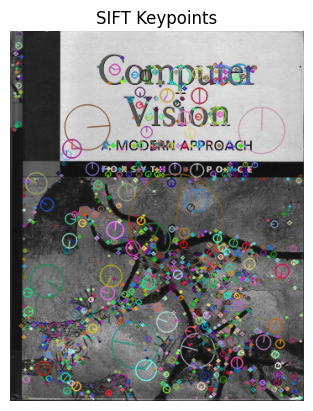

In [476]:
image1 = read_image('assignment_2_materials\\Part_1\\cv_cover.jpg')
keypoints1, descriptor1 = SIFT(image1)

In [477]:
# Load the video
cap = cv.VideoCapture('assignment_2_materials\\Part_1\\book.mov')
total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
print(total_frames)

641


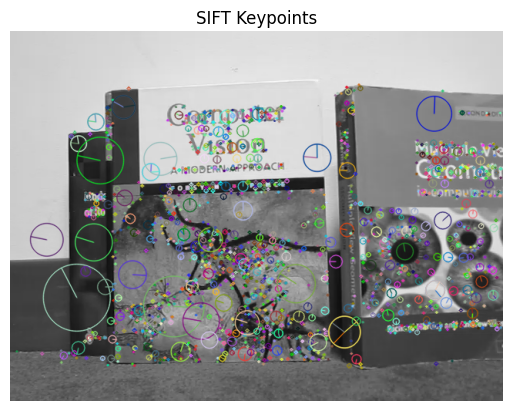

In [478]:
frame_num = 0
# Read the frame
ret, frame = get_frame(frame_num, cap)

if ret:
    keypoints2, descriptor2 = SIFT(frame)

Found 50 good matches
Found 50 good matches


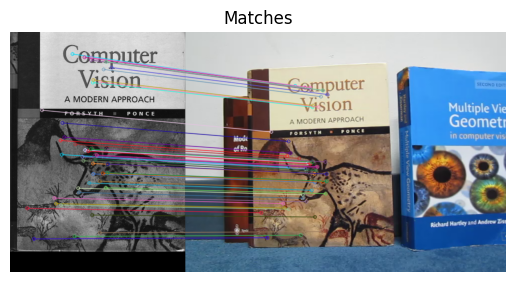

In [479]:
goodMatches1 ,kp1 ,kp2 = knnBruteForce2a(descriptor1, keypoints1 ,descriptor2, keypoints2)
coloredFrame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
goodMatches2 = knnBruteForce(descriptor1, descriptor2)
drawMatches(image1, coloredFrame, keypoints1, keypoints2, goodMatches2)

# 1.2 Compute Homography Parameters

In [480]:
# def featureMatchingHomography():
def compute_homography(src_pts, dst_pts):
    """
    Compute 3x3 homography matrix H such that dst = H * src
    src_pts and dst_pts are lists of corresponding points [(x, y), ...]
    """
    assert len(src_pts) >= 4 and len(src_pts) == len(dst_pts)

    A = []
    for (x, y), (x_p, y_p) in zip(src_pts, dst_pts):
        A.append([-x, -y, -1, 0, 0, 0, x * x_p, y * x_p])
        A.append([0, 0, 0, -x, -y, -1, x * y_p, y * y_p])

    A = np.array(A)
    b = np.array([x_p for (_, _), (x_p, _) in zip(src_pts, dst_pts)] +
                 [y_p for (_, _), (_, y_p) in zip(src_pts, dst_pts)])

    # Solve Ax = b
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    # Add the last value h33 = 1
    H = np.append(x, 1).reshape(3, 3)
    return H
H = compute_homography(kp1, kp2)
H

array([[-2.00737721e-01,  1.53573206e-01, -2.42154527e+02],
       [-3.02962160e-01,  8.04716540e-02, -2.16320553e+02],
       [ 1.79108349e-04,  7.35225564e-05,  1.00000000e+00]])

In [481]:
def map_points(H, src_pts):
    """
    Maps points from src_pts (source points) to dst_pts (destination points)
    using the homography matrix H.
    """
    mapped_pts = []
    for pt in src_pts:
        pt_homogeneous = np.array([pt[0], pt[1], 1])  # Convert to homogeneous coordinates
        mapped_pt = H.dot(pt_homogeneous)  # Apply homography matrix
        mapped_pt = mapped_pt / mapped_pt[2]  # Convert back from homogeneous to non-homogeneous coordinates
        mapped_pts.append(mapped_pt[:2])  # Return only x, y coordinates
    return mapped_pts

MP= mapped_pts = map_points(H, kp1)    
len(MP)

50

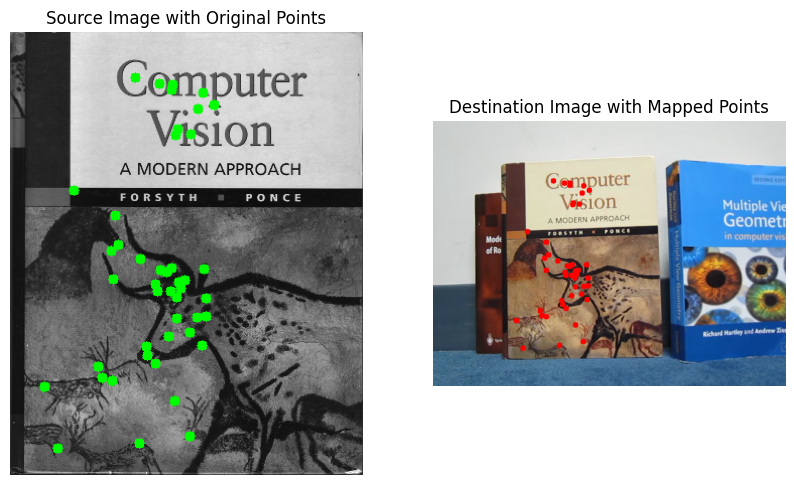

In [482]:
def draw_points(img, points, color=(0, 255, 0), radius=5):
    """
    Draw points on the image using OpenCV.
    """
    for pt in points:
        cv.circle(img, tuple(np.int32(pt)), radius, color, -1)

def visualize_mapping(img1, img2, src_pts, dst_pts, mapped_pts):
    """
    Visualize the mapped points from img1 to img2.
    """
    img1_copy = img1.copy()
    img2_copy = img2.copy()

    # Draw the original points on img1
    draw_points(img1_copy, src_pts, color=(0, 255, 0))  # Green for original points
    # Draw the destination points on img2
    draw_points(img2_copy, dst_pts, color=(255, 0, 0))  # Red for destination points
    # Draw the mapped points on img2
    draw_points(img2_copy, mapped_pts, color=(0, 0, 255))  # Blue for mapped points

    # Show the images
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img1_copy)
    plt.title('Source Image with Original Points')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2_copy)
    plt.title('Destination Image with Mapped Points')
    plt.axis('off')

    plt.show()

visualize_mapping(image1, coloredFrame, kp1, kp2, MP)